# Bayesian Optimization and Feature Comparison with CNN

## Get scripts from GitHub and install wget
Only required when running on Colab. 

In [1]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=5f24242ddf107f949d6fa28c6d9e7b9a308598e3d103b11c76279d7328ec21aa
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [2]:
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/models_utils.py
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/plot_utils.py
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/preprocessing_utils.py

--2023-01-27 09:16:03--  https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/models_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10904 (11K) [text/plain]
Saving to: ‘models_utils.py’

models_utils.py     100%[===================>]  10.65K  --.-KB/s    in 0s      

2023-01-27 09:16:03 (92.1 MB/s) - ‘models_utils.py’ saved [10904/10904]

--2023-01-27 09:16:03--  https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/plot_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225

## Import

In [3]:
import os
import pathlib
import requests
import wget
import inspect

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from IPython.display import display, Audio, Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, log_loss, cohen_kappa_score

from scipy.io import wavfile

from models_utils import available_models, select_model
import plot_utils 

plt.rcParams['font.size'] = '12'
# %matplotlib inline

In [4]:
print("GPU Available:", tf.test.is_gpu_available())
print("Version:", tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True
Version: 2.9.2


To extract MFCC features from audio signals we use the Python library [python_speech_features](https://github.com/jameslyons/python_speech_features).

In [5]:
# uncomment to install python_speech_features
! pip install python_speech_features
! pip install visualkeras

from python_speech_features import logfbank, mfcc, delta
import visualkeras

import preprocessing_utils
from preprocessing_utils import create_dataset, remove_file_starting_with

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=b8b15c8c1f3ed1a2e2b4c8501d4c87e7d5054de24aae9110ed8df562ff740eb1
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 50.7 MB/s eta 0:00:00


To perform Discrete Wavelet Transform on audio signals we use the Python library [PyWavelets](https://github.com/PyWavelets/pywt).

In [6]:
# uncomment to install PyWavelets
! pip install PyWavelets

from pywt import dwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1 - Data loading 
In this project we use the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands), which contains short (one-second long) audio clips of English commands, stored as audio files in the WAV format. More in detail, the version 0.02 of the dataset contains 105.829 utterances of 35 short words, by thousands of different people. It was released on April 11th 2018 under [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/) and collected using crowdsourcing, through [AIY](https://aiyprojects.withgoogle.com/) by Google. Some of these words are "yes", "no", "up", "down", "left", "right", "on", "off", "stop" and "go".

### 1.1 - Download data and create data folder
We import both a smaller version of the Speech Commands dataset and the full version. The mini dataset can be used for testing and demo reasons, however the entire work will be focused only on the complete dataset (or a subset of it). 

In [7]:
choose_dataset = 2 # 1 for mini, 2 for full
download_also_mini = False

DATASET_PATH_mini = 'data/mini_speech_commands'
DATASET_PATH_full = 'data/full_speech_commands'

data_dir_mini = pathlib.Path(DATASET_PATH_mini)
if not data_dir_mini.exists() and download_also_mini:
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  print('\n')
  
data_dir_full = pathlib.Path(DATASET_PATH_full)
if not data_dir_full.exists():
  tf.keras.utils.get_file(
      'full_speech_commands.zip',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data/full_speech_commands')
  print('\n')
  
if choose_dataset==1:
  data_dir = data_dir_mini
  data_path = DATASET_PATH_mini
  print('Working with the mini dataset!')
elif choose_dataset==2:
  data_dir = data_dir_full
  data_path = DATASET_PATH_full
  print('Working with the full dataset!')
else:
  print("Error, 'choose_dataset' must be 1 or 2")

2428923189/2428923189 [==============================] - 28s 0us/step


Working with the full dataset!


### 1.1 - Dataset organization
The audio files are organized into folders based on the word they contain. For more details see \[[Warden18](https://arxiv.org/abs/1804.03209)\].

**Mini dataset** <br>
The dataset's audio clips are stored in 8 folders corresponding to each speech command: `down`, `go`, `left`, `no`, `right`, `stop`, `up`, `yes`, and `stop`. 

**Full dataset** <br>
The dataset's audio clips are stored in 35 folders corresponding to each speech command: <br>
`backward`, `bed`, `bird`, `cat`, `dog`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`, `yes`, `zero`




In [8]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

if choose_dataset==1:
  mask = commands != 'README.md'

elif choose_dataset==2:
  mask = (
      np.array(commands != 'README.md')                 &
      np.array(commands != 'LICENSE')                   &
      np.array(commands != '.DS_Store')                 &
      np.array(commands != 'training_list.txt')         &  
      np.array(commands != 'validation_list.txt')       &  
      np.array(commands != 'testing_list.txt')          &  
      np.array(commands != 'full_speech_commands.zip')  &
      np.array(commands != '_background_noise_')        
  )
  
commands = sorted(commands[mask])
print('Commands:', commands)

print('\nNumber of commands: %i' %len(commands))

Commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

Number of commands: 35


### 1.2 - Processing of the original audio files 
The original audio files were captured in a variety of formats and then converted to .WAV file at a 16000 sample rate. The audio was then trimmed to a one second length to align most utterances, using the [extract_loudest_section](https://github.com/petewarden/extract_loudest_section) tool. The audio files were then screened for silence or incorrect words, and arranged into folders by label.

### 1.3 - Training, testing and validation sets
The text files `validation_list.txt` and `testing_list.txt` available in the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) contain the paths to all the files in each set, with each path on a new line. Any files that aren't in either of these lists can be considered to be part of the training set. The validation and test set sizes thus obtained are approximatly 10% of the size of the complete set. For more information on how the partition is made, see the README.md file of the dataset. 

The following code performs these operations:
- Load the reference validation and testing files as separated Pandas dataframe objects. 
- Store the path of all audio files in a dictionary. 
- Create the reference file for training data, by storing in a Pandas dataframe object the paths of all files that aren't in the validation or testing list. If it has been already created, we simply import it as we did for the reference validation and testing files. 

To each file we associate the corresponding label (i.e. the name of the folder it is in), so that we get a proper labeling for each file to be used with our loss function. Of course, we still need to load the actual data.

In [9]:
training_list_path = data_path + "/training_list.txt"

reference_df_val = pd.read_csv(data_path+"/validation_list.txt", sep="/", header=None, names=['label', 'file'])
reference_df_test = pd.read_csv(data_path+"/testing_list.txt", sep="/", header=None, names=['label', 'file'])

# all audio files
all_files = {}
for command in commands:
    all_files[command] = os.listdir(data_path+'/'+command)
    
num_files = 0
for x_ in all_files.values():
    num_files += len(x_)
        
print('There are %i audio files in the dataset' %num_files)

# reference file for training set
# if already exists import it
if pathlib.Path(training_list_path).exists(): 
    reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])
    
# else search if it can be dowloaded
else: 
  training_list_url = 'https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/training_list.txt'
  response = requests.get(training_list_url)

  if response.status_code == 200:
      wget.download(training_list_url, out=str(data_path))
      print('File downloaded from GitHub')

      reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])

  else: # create it and store the dataframe as a .txt file; creating the pd object can take some time
      print('File not found, error '+str(response.status_code))

      reference_df_train = pd.DataFrame(columns=['label', 'file'])
      for i, command in enumerate(commands):
          print("Processing command '%s', %i commands missing..." %(command, len(commands)-i-1))
          for file in all_files[command]:
              if file in reference_df_val['file'].values:
                  continue
              if file in reference_df_test['file'].values:
                  continue

              reference_df_train.loc[len(reference_df_train)] = [command, file]

      print('Done!')
      print('\n')

      # store reference_df_train in .txt file
      reference_df_train.to_csv(data_path+'/training_list.txt', header=None, index=None, sep='/', mode='a')

# print the result
# print('----------------------------')
# print('TRAINING FILES:')
# print(reference_df_train)
# print('----------------------------')
# print('VALIDATION FILES:')
# print(reference_df_val)
# print('----------------------------')
# print('TESTING FILES:')
# print(reference_df_test)

There are 105829 audio files in the dataset
File downloaded from GitHub


Encode target labels with value between 0 and n_commands-1.

In [10]:
label_to_class = {commands[i]:i for i in range(len(commands))}
# label_to_class

In [11]:
class_to_label = {i:commands[i] for i in range(len(commands))}
# class_to_label

In [12]:
reference_df_train['class'] = reference_df_train['label'].map(label_to_class)
reference_df_val['class']   = reference_df_val['label'].map(label_to_class)
reference_df_test['class']  = reference_df_test['label'].map(label_to_class)

# print the result
print('TRAINING FILES:')
print(reference_df_train)
print('----------------------------')
print('VALIDATION FILES:')
print(reference_df_val)
print('----------------------------')
print('TESTING FILES:')
print(reference_df_test)

TRAINING FILES:
          label                   file  class
0      backward  0165e0e8_nohash_0.wav      0
1      backward  017c4098_nohash_0.wav      0
2      backward  017c4098_nohash_1.wav      0
3      backward  017c4098_nohash_2.wav      0
4      backward  017c4098_nohash_3.wav      0
...         ...                    ...    ...
84838      zero  ffd2ba2f_nohash_1.wav     34
84839      zero  ffd2ba2f_nohash_2.wav     34
84840      zero  ffd2ba2f_nohash_3.wav     34
84841      zero  ffd2ba2f_nohash_4.wav     34
84842      zero  fffcabd1_nohash_0.wav     34

[84843 rows x 3 columns]
----------------------------
VALIDATION FILES:
      label                   file  class
0     right  a69b9b3e_nohash_0.wav     22
1     right  439c84f4_nohash_1.wav     22
2     right  409c962a_nohash_1.wav     22
3     right  dbaf8fc6_nohash_2.wav     22
4     right  a6d586b7_nohash_1.wav     22
...     ...                    ...    ...
9976   four  d107dc42_nohash_0.wav     10
9977   four  ad63d93c_n

In [13]:
print('TRAINING SET')
print('\tnumber of audio files: %i' %len(reference_df_train))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_train)/num_files*100))

print('VALIDATION SET')
print('\tnumber of audio files: %i' %len(reference_df_val))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_val)/num_files*100))

print('TEST SET')
print('\tnumber of audio files: %i' %len(reference_df_test))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_test)/num_files*100))

TRAINING SET
	number of audio files: 84843
	percentage of audio files: 80.17%
VALIDATION SET
	number of audio files: 9981
	percentage of audio files: 9.43%
TEST SET
	number of audio files: 11005
	percentage of audio files: 10.40%


### 1.4 Noise loading 
We load here the available noisy audio signals and we defined the object `noise_dict`, which is required by the function `load_and_preprocessing_data` (see next section).

In [14]:
noise_path = '_background_noise_'

# load all noises 
noise_1 = preprocessing_utils.load_data('doing_the_dishes.wav', noise_path)
noise_2 = preprocessing_utils.load_data('dude_miaowing.wav', noise_path)
noise_3 = preprocessing_utils.load_data('exercise_bike.wav', noise_path)
noise_4 = preprocessing_utils.load_data('pink_noise.wav', noise_path)
noise_5 = preprocessing_utils.load_data('running_tap.wav', noise_path)
noise_6 = preprocessing_utils.load_data('white_noise.wav', noise_path)

noise_dict = {
    '1': noise_1, 
    '2': noise_2, 
    '3': noise_3, 
    '4': noise_4, 
    '5': noise_5, 
    '6': noise_6
}

/content/preprocessing_utils.py:70: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


## 2 - Data Loading using the Dataset API
As the dataset is quite large (>5GiB), there is the risk that it will not entirely fit in the memory, plus the preprocessing pipeline would be computationally intensive. For these reasons, we want to implement a proper and optimized data-loading pipeline, as reading the data can be the main bottleneck of the entire training process. This can be done by exploit the [Tensorflow Dataset API](https://www.tensorflow.org/guide/datasets).

The main goal of this phase is to create a `tf.data.Dataset` object to efficiently load and preprocess your data. 

### 2.1 Loading and preprocessing
First, to load and preprocess the data, we use the function `load_and_preprocess_data`, defined in the file `preprocessing_utils.py`. This function puts together all loading and preprocessing methods that can be explored in the notebook `B1_data_analysis_and_preprocessing_inspection.ipynb`. 



In [15]:
print(inspect.getsource(preprocessing_utils.load_and_preprocess_data))

def load_and_preprocess_data(file_name, file_label, data_path_=data_path):

    # load data
    data = load_data(file_name, file_label, data_path_=data_path_)
    
    # padding/trimming
    data = padding_trimming(data)
        
    # TensorFlow takes as input 32-bit floating point data
    return data.astype(np.float32)



### 2.2 - Dataset definition
We now use the function `create_dataset`, defined in the file `preprocessing_utils.py`. This function initializes a `tf.data.Dataset` object and properly maps all the required processing. More details on this procedure can be found [here](https://www.tensorflow.org/guide/performance/datasets), along with additional tips and tricks for performance optimization.

In [16]:
print(inspect.getsource(preprocessing_utils.create_dataset))

def create_dataset(df, is_train=True, data_path_=data_path, cache_file=None, shuffle=True, apply_random_shift=False, apply_background_noise=False, noise_dict=None, noise_reduction=0.5, features=1, batch_size=32):
    '''
    features:
    - 1 for MFCC features [delta_order=2] (default)
    - 2 for log Mel-filterbank energy features
    - 3 for spectrogram
    - 4 for Discrete Wavelet Transform + MFCC features
    - 5 for MFCC features [delta_order=0]
    - 6 for log Mel-filterbank energy features [winlen=32, winstep=15.5, nfilt=64]
    - 7 for log Mel-filterbank energy features [winlen=25, winstep=8,    nfilt=80]
    '''

    # Convert DataFrame to lists
    file_names  = df['file'].tolist()
    file_labels = df['class'].tolist()

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, file_labels))

    # Map the "load_and_preprocess_data" function
    dataset = dataset.map(lambda file_name, file_label: (tf.numpy_function(load_and_preprocess_data, [

### 2.3 - Dataset initialization
Finally, we define the training, validation and testing dataset, applying the above function to each of the corresponding reference dataframes. We also evaluate the number of steps (*train_steps*, *val_steps* and *test_steps*) required to load and process the entire dataset (num. of samples / batch_size).

We perform the Bayesian Optimization using the log Mel-filterbank energies, as from some preliminary tests we have seen that they could lead to best performances. For this reason we set `features_to_extract=2`.

In [23]:
apply_bn = True
noise_red = 0.5
features_to_extract = 2 # for log Mel-filterbank energy features
batch_size = 32

train_dataset, train_steps = create_dataset(
    reference_df_train,
    is_train=True,
    cache_file='train_cache',
    shuffle=True,
    apply_background_noise=apply_bn,
    noise_dict=noise_dict,
    noise_reduction=noise_red,
    features=features_to_extract,
    batch_size=batch_size
)

val_dataset, val_steps = create_dataset(
    reference_df_val,
    is_train=False,
    cache_file='val_cache',
    shuffle=True,
    apply_background_noise=False,
    features=features_to_extract,
    batch_size=batch_size
)

# important! shuffle=False
test_dataset, test_steps = create_dataset(
    reference_df_test,
    is_train=False,
    cache_file='test_cache',
    shuffle=False,
    apply_background_noise=False,
    features=features_to_extract,
    batch_size=batch_size
)

# Bayesian Optimization

## 3 - BO, introduction
Bayesian optimization is a strategy to find the optimum of a black-box function, whose analytic form is not known and which is expensive to evaluate. The optimization is achieved through a sequential data
driven scenario, where the goal is to improve the guess of the optimum while being data efficient in terms of how many queries we ask of the black-box. In this case we apply it to find the CNN model parameter values that lead to the best accuracy.

For more information, refer to the following references: 
- [Bayesian optimization with skopt — scikit-optimize 0.8.1 documentation](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html)
- [Bayesian Optimisation: Gaussian processes & Beyond — Haitham Bou Ammar (LinkedIn)](https://www.linkedin.com/posts/haitham-bou-ammar-a723a932_long-bayesian-optimisation-talk-from-simple-activity-6989891577967968256-b6DC?utm_source=share&utm_medium=member_desktop)

### 3.0 - Import for BO

In [ ]:
!pip install -q scikit-optimize

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

from skopt import gp_minimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 6.9 MB/s eta 0:00:00


### 3.1 - Model definition

In [19]:
features_to_input = { # input shapes
    1 : (99, 39),     # MFCC features with delta
    2 : (99, 40),     # log Mel-filterbank energy features
    3 : (98, 257),    # spectrogram
    4 : (49, 39),     # Discrete Wavelet Transform + MFCC features
    5 : (99, 13)      # MFCC features no delta
}

input_shape = features_to_input[features_to_extract]

def custom_cnn_simple(
    input_shape, 
    nf_sp_1, nf_sp_2, nk_sp_l, nk_sp_r, mp_sp, dp_sp, 
    nf_tp_1, nf_tp_2, nk_tp_l, nk_tp_r, mp_tp_1, mp_tp_2, dp_tp, 
    dp_fc, lr
    ):
    '''
      4 cnn blocks, 2x pooling, 2x pooling in time
    '''

    model = tf.keras.models.Sequential(name='custom_cnn')

    model.add(tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(input_shape[0], input_shape[1], 1)))
    model.add(tf.keras.layers.BatchNormalization())

    filters_pool = [nf_sp_1, nf_sp_2]

    for num_filters in filters_pool:

      model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=(nk_sp_l, nk_sp_r), padding='same'))
      model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Activation('relu'))

      model.add(tf.keras.layers.MaxPooling2D(pool_size=(mp_sp, mp_sp)))
      model.add(tf.keras.layers.Dropout(dp_sp))

    filters_pool_in_time = [nf_tp_1, nf_tp_2]

    for p, num_filters in zip([mp_tp_1, mp_tp_2], filters_pool_in_time):

      model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=(nk_tp_l, nk_tp_r), padding='same'))
      model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Activation('relu'))

      model.add(tf.keras.layers.MaxPooling2D(pool_size=(p, 1)))
      model.add(tf.keras.layers.Dropout(dp_tp))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(dp_fc))
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(35, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=["sparse_categorical_accuracy"])

    return model

model_name = 'custom_cnn_simple'

### 3.2 - Search space dimensions and objective function

In [ ]:
search_space  = [
    Integer(2, 128, name='nf_sp_1'),
    Integer(2, 128, name='nf_sp_2'),
    Integer(2, 8, name='nk_sp_l'),
    Integer(2, 8, name='nk_sp_r'),
    Integer(1, 3, name='mp_sp'),
    Real(0.1, 0.5, name='dp_sp'),

    Integer(8, 256, name='nf_tp_1'),
    Integer(8, 256, name='nf_tp_2'),
    Integer(2, 8, name='nk_tp_l'),
    Integer(2, 8, name='nk_tp_r'),
    Integer(1, 3, name='mp_tp_1'),
    Integer(1, 3, name='mp_tp_2'),
    Real(0.1, 0.5, name='dp_tp'),

    Real(0.1, 0.5, name='dp_fc'),
    Real(1e-6, 1e-2, 'log-uniform', name='lr')
]

In [ ]:
@use_named_args(search_space)
def objective_f(nf_sp_1, nf_sp_2, nk_sp_l, nk_sp_r, mp_sp, dp_sp, 
      nf_tp_1, nf_tp_2, nk_tp_l, nk_tp_r, mp_tp_1, mp_tp_2, dp_tp, 
      dp_fc, lr):
    model = custom_cnn_simple(
      input_shape, 
      nf_sp_1, nf_sp_2, nk_sp_l, nk_sp_r, mp_sp, dp_sp, 
      nf_tp_1, nf_tp_2, nk_tp_l, nk_tp_r, mp_tp_1, mp_tp_2, dp_tp, 
      dp_fc, lr
    )
    
    num_epochs = 20

    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
    
    history = model.fit(
                train_dataset,
                epochs=num_epochs,
                steps_per_epoch=train_steps,
                validation_data=val_dataset,
                validation_steps=val_steps,
                callbacks=[early_stop_callback, reduce_LR], 
                verbose=0
                )
    
    # get last epoch accuracy and print is
    accuracy = history.history['val_sparse_categorical_accuracy'][-1]
    
    print("\n\nAccuracy: {0:.2%}\n\n".format(accuracy))

    # clean memory: delete model and clean session 
    del model
    
    tf.keras.backend.clear_session()

    return -accuracy # minus because it returns what we want to minimize

In [ ]:
bo_result = gp_minimize(func=objective_f,
                            dimensions=search_space,
                            n_calls=30,
                            verbose=True)

Iteration No: 1 started. Evaluating function at random point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Accuracy: 91.18%


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5723.5120
Function value obtained: -0.9118
Current minimum: -0.9118
Iteration No: 2 started. Evaluating function at random point.


Accuracy: 67.21%


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 743.0302
Function value obtained: -0.6721
Current minimum: -0.9118
Iteration No: 3 started. Evaluating function at random point.


Accuracy: 80.86%


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 923.2033
Function value obtained: -0.8086
Current minimum: -0.9118
Iteration No: 4 started. Evaluating function at random point.


Accuracy: 87.76%


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 983.1694
Function value obtained: -0.8776
Current minimum: -0.9118
Iteration No: 5 started. Evaluating function at random point.


Accuracy: 67.22%


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 878.4694
Function value obtained: -0.6

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 15: ReduceLROnPlateau reducing learning rate to 4.05108803533949e-06.

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.05108812628896e-07.


Accuracy: 91.49%


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 6023.5126
Function value obtained: -0.9149
Current minimum: -0.9149
Iteration No: 12 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Accuracy: 77.46%


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 904.3447
Function value obtained: -0.7746
Current minimum: -0.9149
Iteration No: 13 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Accuracy: 79.45%


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 803.6716
Function value obtained: -0.7945
Current minimum: -0.9149
Iteration No: 14 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Accuracy: 83.74%


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1044.0244
Function value obtained: -0.8374
Current minimum: -0.9149
Iteration No: 15 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 18: ReduceLROnPlateau reducing learning rate to 2.9234515750431456e-06.


Accuracy: 89.88%


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 6143.5191
Function value obtained: -0.8988
Current minimum: -0.9149
Iteration No: 16 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 10: ReduceLROnPlateau reducing learning rate to 1.6177868019440213e-06.


Accuracy: 31.74%


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 383.4020
Function value obtained: -0.3174
Current minimum: -0.9149
Iteration No: 17 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 19: ReduceLROnPlateau reducing learning rate to 6.540543108712882e-06.


Accuracy: 90.78%


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 743.5392
Function value obtained: -0.9078
Current minimum: -0.9149
Iteration No: 18 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00022847854997962714.

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.2847854415886105e-05.


Accuracy: 91.71%


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 3863.5165
Function value obtained: -0.9171
Current minimum: -0.9171
Iteration No: 19 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 10: ReduceLROnPlateau reducing learning rate to 2.055695658782497e-05.

Epoch 16: ReduceLROnPlateau reducing learning rate to 2.055695586022921e-06.


Accuracy: 91.61%


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 4584.9453
Function value obtained: -0.9161
Current minimum: -0.9171
Iteration No: 20 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0009554545395076275.

Epoch 15: ReduceLROnPlateau reducing learning rate to 9.554545395076276e-05.


Accuracy: 89.25%


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 429.8047
Function value obtained: -0.8925
Current minimum: -0.9171
Iteration No: 21 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 3.523117047734559e-05.

Epoch 14: ReduceLROnPlateau reducing learning rate to 3.5231169022154063e-06.


Accuracy: 90.11%


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 3323.4001
Function value obtained: -0.9011
Current minimum: -0.9171
Iteration No: 22 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 18: ReduceLROnPlateau reducing learning rate to 8.384155808016659e-06.


Accuracy: 92.48%


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 5363.9511
Function value obtained: -0.9248
Current minimum: -0.9248
Iteration No: 23 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0007373829372227192.

Epoch 17: ReduceLROnPlateau reducing learning rate to 7.37382913939655e-05.


Accuracy: 93.21%


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 922.0916
Function value obtained: -0.9321
Current minimum: -0.9321
Iteration No: 24 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 11: ReduceLROnPlateau reducing learning rate to 2.1247580298222603e-05.

Epoch 16: ReduceLROnPlateau reducing learning rate to 2.1247580662020484e-06.


Accuracy: 92.74%


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 5022.9299
Function value obtained: -0.9274
Current minimum: -0.9321
Iteration No: 25 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Accuracy: 85.61%


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1043.6623
Function value obtained: -0.8561
Current minimum: -0.9321
Iteration No: 26 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0007281574420630933.


Accuracy: 92.93%


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2876.6627
Function value obtained: -0.9293
Current minimum: -0.9321
Iteration No: 27 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0061615466838704e-05.

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.0061615284939763e-06.


Accuracy: 92.47%


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 4732.1137
Function value obtained: -0.9247
Current minimum: -0.9321
Iteration No: 28 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 13: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.


Accuracy: 92.61%


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3220.7459
Function value obtained: -0.9261
Current minimum: -0.9321
Iteration No: 29 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00017483937554061413.


Accuracy: 92.55%


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 6507.9529
Function value obtained: -0.9255
Current minimum: -0.9321
Iteration No: 30 started. Searching for the next optimal point.


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0006198943126946688.


Accuracy: 89.50%


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 470.8903
Function value obtained: -0.8950
Current minimum: -0.9321


In [ ]:
bo_parameters = {p.name: value for p, value in zip(search_space, bo_result.x)}
print('Parameters obtained via the Bayesian Optimization:\n')

for i in bo_parameters:
  print(i, '=', bo_parameters[i])

# print('\n')
# plot_convergence(bo_result)
# plt.show()

Parameters obtained via the Bayesian Optimization:

nf_sp_1 = 48
nf_sp_2 = 30
nk_sp_l = 8
nk_sp_r = 3
mp_sp = 2
dp_sp = 0.3208725109346078
nf_tp_1 = 213
nf_tp_2 = 70
nk_tp_l = 6
nk_tp_r = 8
mp_tp_1 = 3
mp_tp_2 = 1
dp_tp = 0.29021674764792915
dp_fc = 0.17477829885526042
lr = 0.0073738292402841825


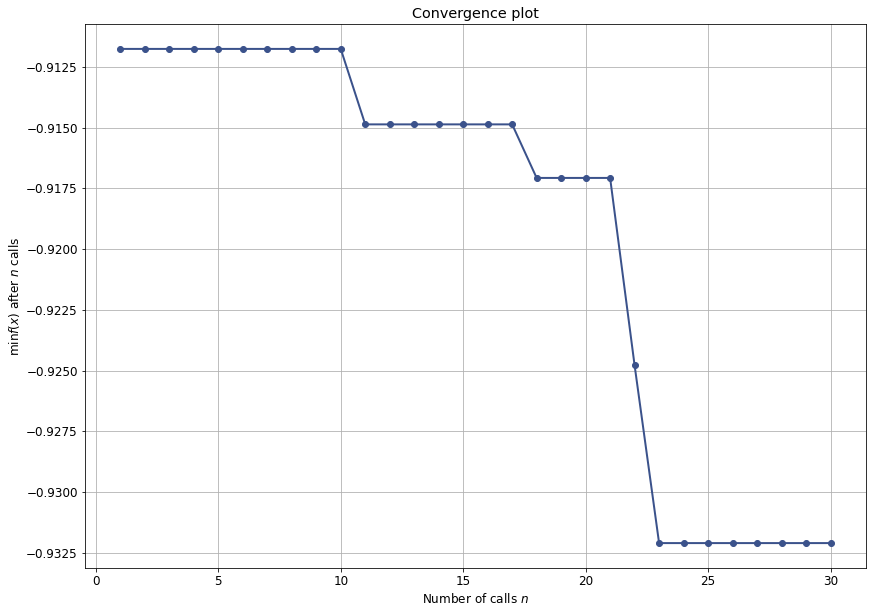

In [ ]:
plt.rcParams["figure.figsize"] = (14,10)
plot_convergence(bo_result)
plt.savefig('bayesian_optimization.svg', dpi=300, facecolor='white')

## 4 - Best model, training and testing


### 4.0 - Best model import

Model: "custom_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 99, 40, 1)         0         
                                                                 
 batch_normalization (BatchN  (None, 99, 40, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 99, 40, 48)        1200      
                                                                 
 batch_normalization_1 (Batc  (None, 99, 40, 48)       192       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 99, 40, 48)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 20, 48)       0

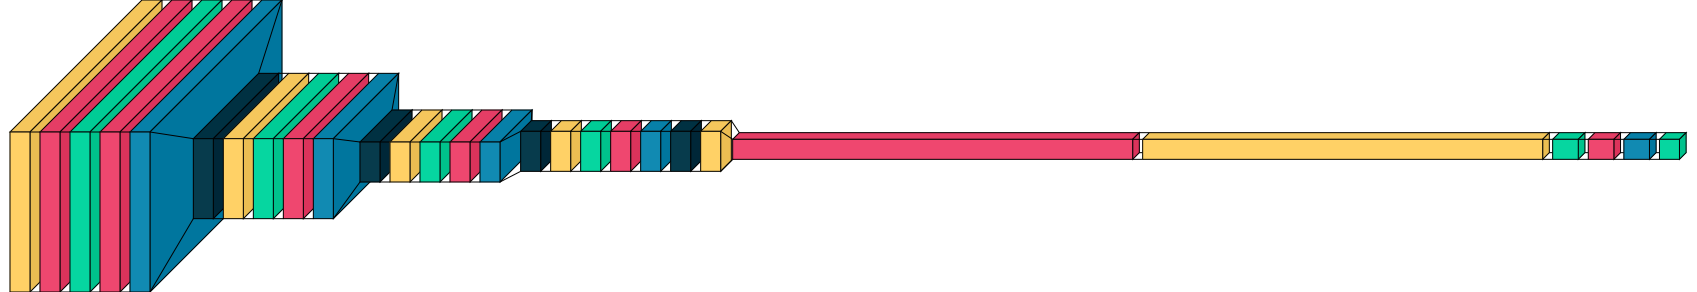

In [20]:
bo_params_redefined = [48, 32, 8, 3, 2, 0.3, 128, 64, 5, 5, 3, 1, 0.3, 0.2, 0.01]

model = custom_cnn_simple(input_shape, *bo_params_redefined)
model_name = 'custom_cnn_simple'

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model.summary()

visualkeras.layered_view(model)

### 4.1 - Model training
At this point we can train the model for some epochs.

In [ ]:
import time
start_time = time.time()

num_epochs = 30

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
                train_dataset,
                epochs=num_epochs,
                steps_per_epoch=train_steps,
                validation_data=val_dataset,
                validation_steps=val_steps,
                callbacks=[early_stop_callback, model_checkpoint, reduce_LR], 
                verbose=1
                )

print("\n--- Training time: %s seconds ---" % (time.time() - start_time))

Epoch 1/30
2652/2652 [==============================] - 40s 14ms/step - loss: 1.1444 - sparse_categorical_accuracy: 0.6641 - val_loss: 0.5291 - val_sparse_categorical_accuracy: 0.8412 - lr: 0.0010
Epoch 2/30
2652/2652 [==============================] - 35s 13ms/step - loss: 0.6201 - sparse_categorical_accuracy: 0.8126 - val_loss: 0.4425 - val_sparse_categorical_accuracy: 0.8668 - lr: 0.0010
Epoch 3/30
2652/2652 [==============================] - 35s 13ms/step - loss: 0.5141 - sparse_categorical_accuracy: 0.8426 - val_loss: 0.4123 - val_sparse_categorical_accuracy: 0.8733 - lr: 0.0010
Epoch 4/30
2652/2652 [==============================] - 38s 14ms/step - loss: 0.4508 - sparse_categorical_accuracy: 0.8618 - val_loss: 0.3423 - val_sparse_categorical_accuracy: 0.8975 - lr: 0.0010
Epoch 5/30
2652/2652 [==============================] - 36s 14ms/step - loss: 0.4107 - sparse_categorical_accuracy: 0.8743 - val_loss: 0.3472 - val_sparse_categorical_accuracy: 0.8947 - lr: 0.0010
Epoch 6/30
2652

In [ ]:
print('Training history:')
pd.DataFrame(history.history)

Training history:


,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,lr
0,1.144419,0.664098,0.529104,0.841246,0.00100
1,0.620087,0.812571,0.442531,0.866787,0.00100
2,0.514116,0.842607,0.412306,0.873297,0.00100
3,0.450812,0.861814,0.342255,0.897536,0.00100
4,0.410683,0.874317,0.347168,0.894732,0.00100
5,0.376468,0.883779,0.332693,0.897636,0.00100
6,0.354026,0.889812,0.317141,0.903946,0.00100
7,0.330532,0.896658,0.290663,0.913061,0.00100
8,0.314081,0.901702,0.297845,0.911959,0.00100
9,0.298196,0.906710,0.288654,0.915465,0.00100


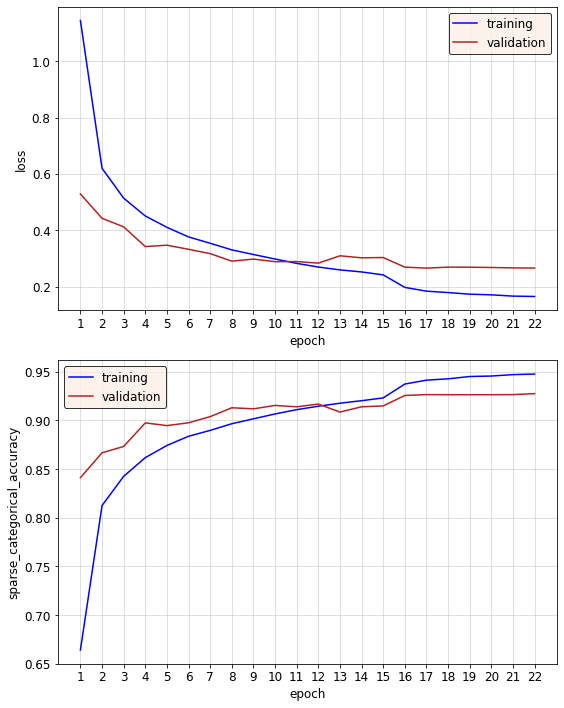

In [ ]:
plot_utils.plot_history(history, columns=['loss', 'sparse_categorical_accuracy'])

Uncomment the cell below to save the trained model.

In [ ]:
model.save(f'trained_models/{model_name}.h5')

try:
  from google.colab import files
  files.download(f'trained_models/{model_name}.h5')

except:
  pass

### 4.2 - Validation metrics

In [ ]:
# get predictions for test set
test_labels = reference_df_test['class']
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(test_labels)].squeeze()

# estimate class
y_pred = np.argmax(test_pred, axis=1)

# true labels
y_true = reference_df_test['class'].tolist()

344/344 [==============================] - 45s 130ms/step


Plot the confusion matrix:

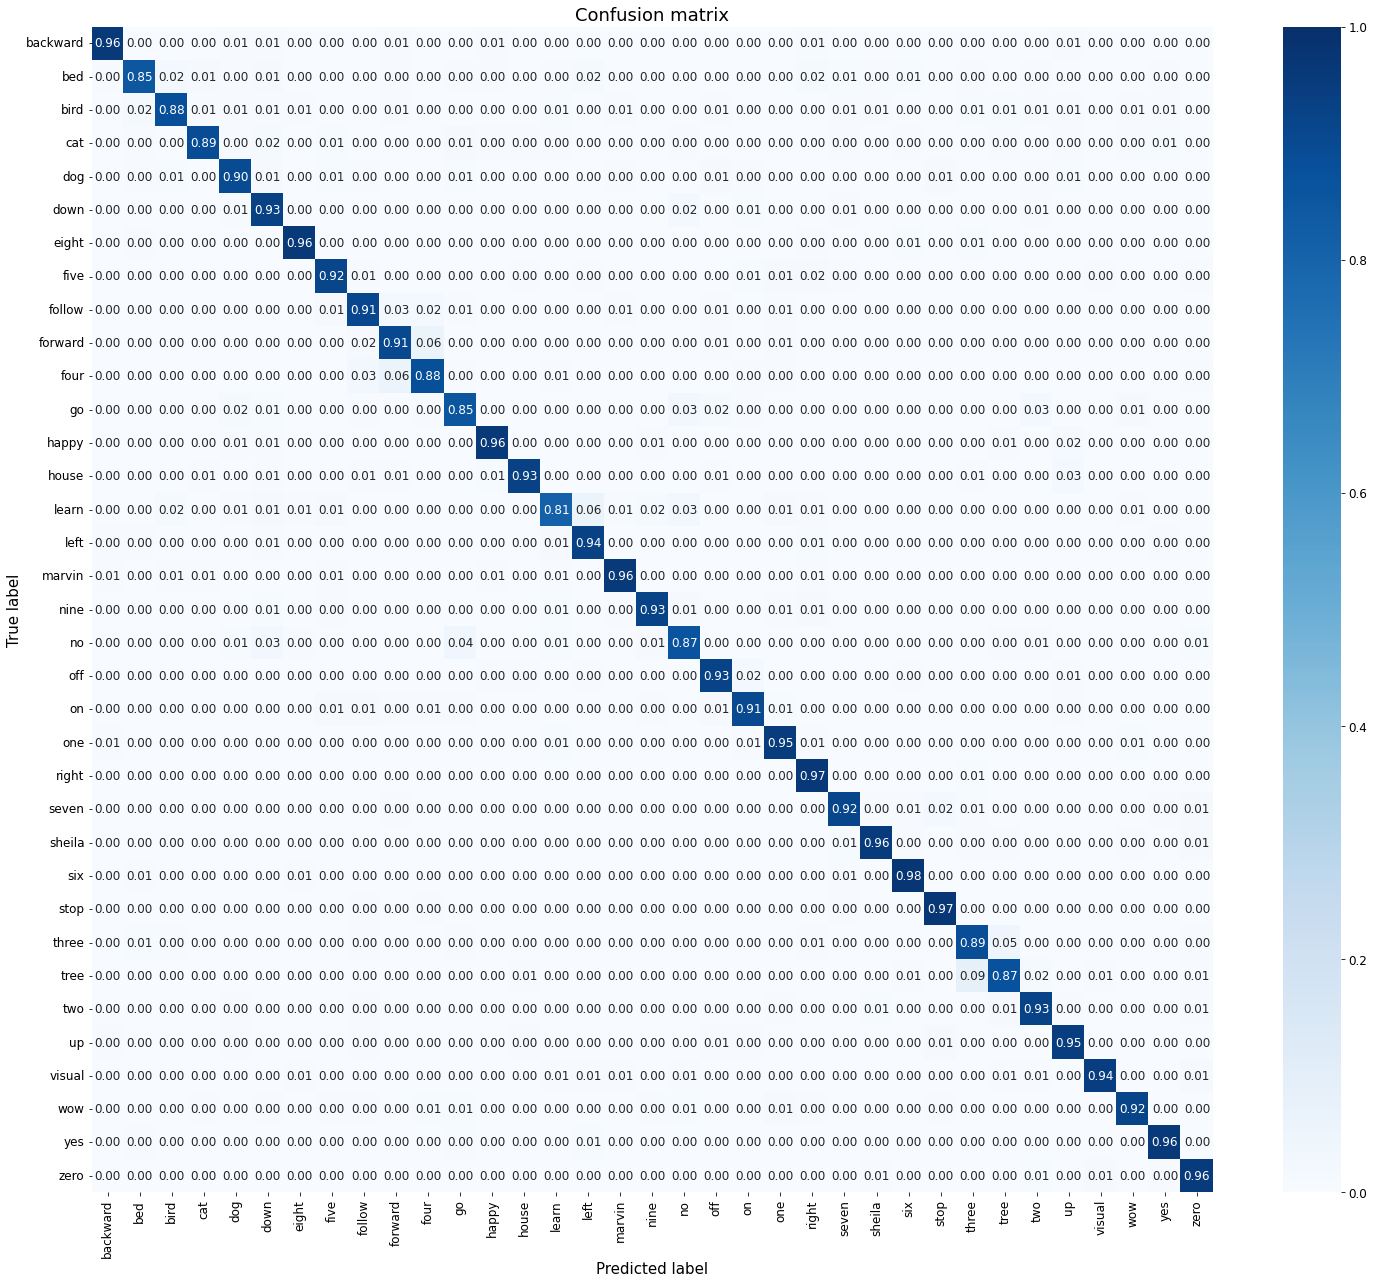

In [ ]:
cm = confusion_matrix(y_pred, y_true)
plot_utils.plot_confusion_matrix(cm, labels=commands, normalize=True, saveit=False, model_name='')
# plt.savefig(f'figures/cm_{model_name}.png')

Evaluate some metrics:



In [28]:
def class_report(y_true, y_pred):
    precision_macro,    recall_macro,    fscore_macro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='macro')
    precision_micro,    recall_micro,    fscore_micro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='micro')
    precision_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted')
    
    df_report = pd.DataFrame(
        {
            'precision': [precision_macro, precision_micro, precision_weighted],
            'recall': [recall_macro, recall_micro, recall_weighted],
            'f1-score': [fscore_macro, fscore_micro, fscore_weighted]
        }, 
        index=['macro', 'micro', 'weighted']
    )
    
    return df_report

In [ ]:
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

# print('Accuracy:      {:.2f}%'.format(accuracy*100))
# print('Error rate:    {:.2f}%'.format((1-accuracy)*100))
# print('Cross-entropy: {:.4f}'.format(logloss))
# print("Cohen's Kappa: {:.4f}".format(cohen_k))

cr = class_report(y_true, y_pred)

In [ ]:
# print('Testing of model %s with features %i...\n' %(model_name, features_to_extract))
weighted_metrics = cr.iloc[-1].tolist()

df_metrics_simple = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

display(df_metrics_simple.round(4))

# Uncomment next lines to store the final metrics 
# if not os.path.exists("metrics"):
#   os.mkdir('metrics')
#   
# df_metrics.to_csv(f'metrics/metr_{model_name}_2.csv')

,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.9248,0.9241,0.9241,0.9241,0.2644,0.9216


In [ ]:
# tmp1 = pd.read_csv('metr_smallCnnModel_1.csv', index_col=0)
# tmp2 = pd.read_csv('metr_smallCnnModel_2.csv', index_col=0)
# 
# df_ = pd.concat([tmp1, tmp2], ignore_index=True, axis=0)
# df_['Training'] = ['Without Delta', 'With Delta']
# df_ = df_.set_index(['Training'])
# df_

## 5 - Dropout and Batch Normalization effect

In [ ]:
def custom_cnn_simple_nodrop_nobatchnorm(
    input_shape, 
    nf_sp_1, nf_sp_2, nk_sp_l, nk_sp_r, mp_sp, dp_sp, 
    nf_tp_1, nf_tp_2, nk_tp_l, nk_tp_r, mp_tp_1, mp_tp_2, dp_tp, 
    dp_fc, lr, 
    drop = True, batchnorm=True
    ):

    model = tf.keras.models.Sequential(name='custom_cnn')

    model.add(tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(input_shape[0], input_shape[1], 1)))
    if batchnorm: model.add(tf.keras.layers.BatchNormalization())

    filters_pool = [nf_sp_1, nf_sp_2]

    for num_filters in filters_pool:

      model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=(nk_sp_l, nk_sp_r), padding='same'))
      if batchnorm: model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Activation('relu'))

      model.add(tf.keras.layers.MaxPooling2D(pool_size=(mp_sp, mp_sp)))
      if drop: model.add(tf.keras.layers.Dropout(dp_sp))

    filters_pool_in_time = [nf_tp_1, nf_tp_2]

    for p, num_filters in zip([mp_tp_1, mp_tp_2], filters_pool_in_time):

      model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=(nk_tp_l, nk_tp_r), padding='same'))
      if batchnorm: model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Activation('relu'))

      model.add(tf.keras.layers.MaxPooling2D(pool_size=(p, 1)))
      if drop: model.add(tf.keras.layers.Dropout(dp_tp))

    model.add(tf.keras.layers.Flatten())
    if drop: model.add(tf.keras.layers.Dropout(dp_fc))
    model.add(tf.keras.layers.Dense(256))
    if batchnorm: model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(35, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=["sparse_categorical_accuracy"])

    return model

### 5.1 - NO dropout

In [ ]:
del model

model = custom_cnn_simple_nodrop_nobatchnorm(input_shape, *bo_params_redefined, drop = False, batchnorm=True)
model_name = 'custom_cnn_simple_nodropout'

In [ ]:
start_time = time.time()

num_epochs = 30

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
                train_dataset,
                epochs=num_epochs,
                steps_per_epoch=train_steps,
                validation_data=val_dataset,
                validation_steps=val_steps,
                callbacks=[early_stop_callback, model_checkpoint, reduce_LR], 
                verbose=1
                )

print("\n--- Training time: %s seconds ---" % (time.time() - start_time))

Epoch 1/30
2652/2652 [==============================] - 36s 13ms/step - loss: 1.0752 - sparse_categorical_accuracy: 0.6839 - val_loss: 0.8255 - val_sparse_categorical_accuracy: 0.7517 - lr: 0.0100
Epoch 2/30
2652/2652 [==============================] - 33s 13ms/step - loss: 0.5325 - sparse_categorical_accuracy: 0.8397 - val_loss: 0.5106 - val_sparse_categorical_accuracy: 0.8482 - lr: 0.0100
Epoch 3/30
2652/2652 [==============================] - 35s 13ms/step - loss: 0.4334 - sparse_categorical_accuracy: 0.8697 - val_loss: 0.4296 - val_sparse_categorical_accuracy: 0.8685 - lr: 0.0100
Epoch 4/30
2652/2652 [==============================] - 34s 13ms/step - loss: 0.3736 - sparse_categorical_accuracy: 0.8862 - val_loss: 0.4304 - val_sparse_categorical_accuracy: 0.8754 - lr: 0.0100
Epoch 5/30
2652/2652 [==============================] - 34s 13ms/step - loss: 0.3287 - sparse_categorical_accuracy: 0.8992 - val_loss: 0.5000 - val_sparse_categorical_accuracy: 0.8516 - lr: 0.0100
Epoch 6/30
2650

In [ ]:
# testing
test_labels = reference_df_test['class']
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(test_labels)].squeeze()

y_pred = np.argmax(test_pred, axis=1)
y_true = reference_df_test['class'].tolist()

accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

cr = class_report(y_true, y_pred)
weighted_metrics = cr.iloc[-1].tolist()

df_metrics = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

print('Training results without dropout:\n')
display(df_metrics)

344/344 [==============================] - 31s 4ms/step
Training results without dropout:



,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.919849,0.9194,0.91942,0.9194,0.322928,0.91672


### 5.2 - NO batch normalization

In [ ]:
del model

model = custom_cnn_simple_nodrop_nobatchnorm(input_shape, *bo_params_redefined, drop = True, batchnorm=False)
model_name = 'custom_cnn_simple_nobatchnorm'

In [ ]:
start_time = time.time()

num_epochs = 30

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
                train_dataset,
                epochs=num_epochs,
                steps_per_epoch=train_steps,
                validation_data=val_dataset,
                validation_steps=val_steps,
                callbacks=[early_stop_callback, model_checkpoint, reduce_LR], 
                verbose=1
                )

print("\n--- Training time: %s seconds ---" % (time.time() - start_time))

Epoch 1/30
2652/2652 [==============================] - 32s 12ms/step - loss: 3.7138 - sparse_categorical_accuracy: 0.0377 - val_loss: 3.4968 - val_sparse_categorical_accuracy: 0.0385 - lr: 0.0100
Epoch 2/30
2652/2652 [==============================] - 30s 11ms/step - loss: 3.5017 - sparse_categorical_accuracy: 0.0372 - val_loss: 3.4968 - val_sparse_categorical_accuracy: 0.0364 - lr: 0.0100
Epoch 3/30
2652/2652 [==============================] - 29s 11ms/step - loss: 3.5018 - sparse_categorical_accuracy: 0.0375 - val_loss: 3.4962 - val_sparse_categorical_accuracy: 0.0357 - lr: 0.0100
Epoch 4/30
2652/2652 [==============================] - 29s 11ms/step - loss: 3.5018 - sparse_categorical_accuracy: 0.0364 - val_loss: 3.4964 - val_sparse_categorical_accuracy: 0.0398 - lr: 0.0100
Epoch 5/30
2652/2652 [==============================] - 29s 11ms/step - loss: 3.5018 - sparse_categorical_accuracy: 0.0372 - val_loss: 3.4958 - val_sparse_categorical_accuracy: 0.0386 - lr: 0.0100
Epoch 6/30
2652

In [ ]:
# testing
test_labels = reference_df_test['class']
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(test_labels)].squeeze()

y_pred = np.argmax(test_pred, axis=1)
y_true = reference_df_test['class'].tolist()

accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

cr = class_report(y_true, y_pred)
weighted_metrics = cr.iloc[-1].tolist()

df_metrics = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

print('Training results without batch normalization:\n')
display(df_metrics)

344/344 [==============================] - 34s 4ms/step
Training results without batch normalization:



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.001443,0.037983,0.00278,0.037983,3.491076,0.0


## 6 - Best model modified, training and testing


### 6.0 - Modified model definition

Model: "custom_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 99, 40, 1)         0         
                                                                 
 batch_normalization_6 (Batc  (None, 99, 40, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 99, 40, 48)        1056      
                                                                 
 batch_normalization_7 (Batc  (None, 99, 40, 48)       192       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 99, 40, 48)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 99, 40, 48)        4

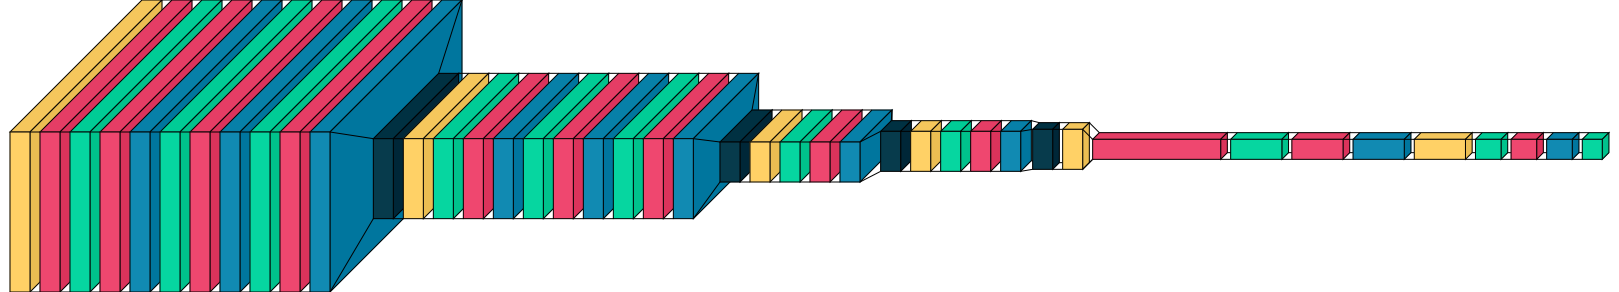

In [ ]:
def custom_cnn(input_shape):

    model = tf.keras.models.Sequential(name='custom_cnn')

    model.add(tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(input_shape[0], input_shape[1], 1)))
    model.add(tf.keras.layers.BatchNormalization())

    filters_pool = [48, 32]

    for num_filters in filters_pool:

        model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=(7, 3), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=(7, 3), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=(7, 3), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.3))

    filters_pool_in_time = [128, 64]

    for p, num_filters in zip([3, 3], filters_pool_in_time):

        model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=(5, 7), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))

        model.add(tf.keras.layers.MaxPooling2D(pool_size=(p, 1)))
        model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, name='features512'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(256, name='features256'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(35, activation='softmax'))

    return model

# del model
model = custom_cnn(input_shape)
model_name = 'custom_cnn'

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model.summary()

visualkeras.layered_view(model)

### 6.1 - Model training 

Epoch 1/40
2652/2652 [==============================] - 419s 53ms/step - loss: 1.9137 - sparse_categorical_accuracy: 0.4505 - val_loss: 0.6765 - val_sparse_categorical_accuracy: 0.7891 - lr: 0.0100
Epoch 2/40
2652/2652 [==============================] - 110s 42ms/step - loss: 0.7141 - sparse_categorical_accuracy: 0.7894 - val_loss: 0.4850 - val_sparse_categorical_accuracy: 0.8526 - lr: 0.0100
Epoch 3/40
2652/2652 [==============================] - 109s 41ms/step - loss: 0.5625 - sparse_categorical_accuracy: 0.8349 - val_loss: 0.4926 - val_sparse_categorical_accuracy: 0.8595 - lr: 0.0100
Epoch 4/40
2652/2652 [==============================] - 109s 41ms/step - loss: 0.4825 - sparse_categorical_accuracy: 0.8572 - val_loss: 0.3778 - val_sparse_categorical_accuracy: 0.8901 - lr: 0.0100
Epoch 5/40
2652/2652 [==============================] - 109s 41ms/step - loss: 0.4323 - sparse_categorical_accuracy: 0.8719 - val_loss: 0.3114 - val_sparse_categorical_accuracy: 0.9089 - lr: 0.0100
Epoch 6/40

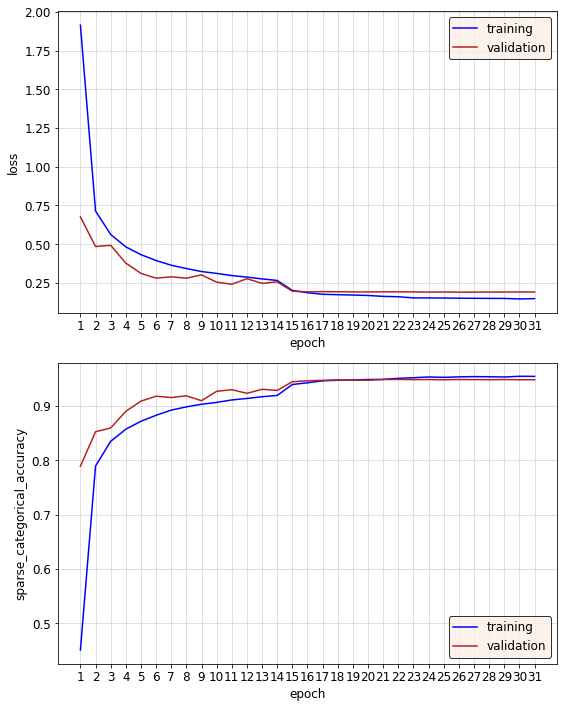

In [ ]:
num_epochs = 40
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
                train_dataset,
                epochs=num_epochs,
                steps_per_epoch=train_steps,
                validation_data=val_dataset,
                validation_steps=val_steps,
                callbacks=[early_stop_callback, model_checkpoint, reduce_LR], 
                verbose=1
                )

print('Training history:')
pd.DataFrame(history.history)

plot_utils.plot_history(history, columns=['loss', 'sparse_categorical_accuracy'])

Uncomment the cell below to save the trained model.

In [ ]:
model.save(f'trained_models/{model_name}.h5')

try:
  from google.colab import files
  files.download(f'trained_models/{model_name}.h5')

except:
  pass

### 6.2 - Validation metrics

344/344 [==============================] - 43s 126ms/step


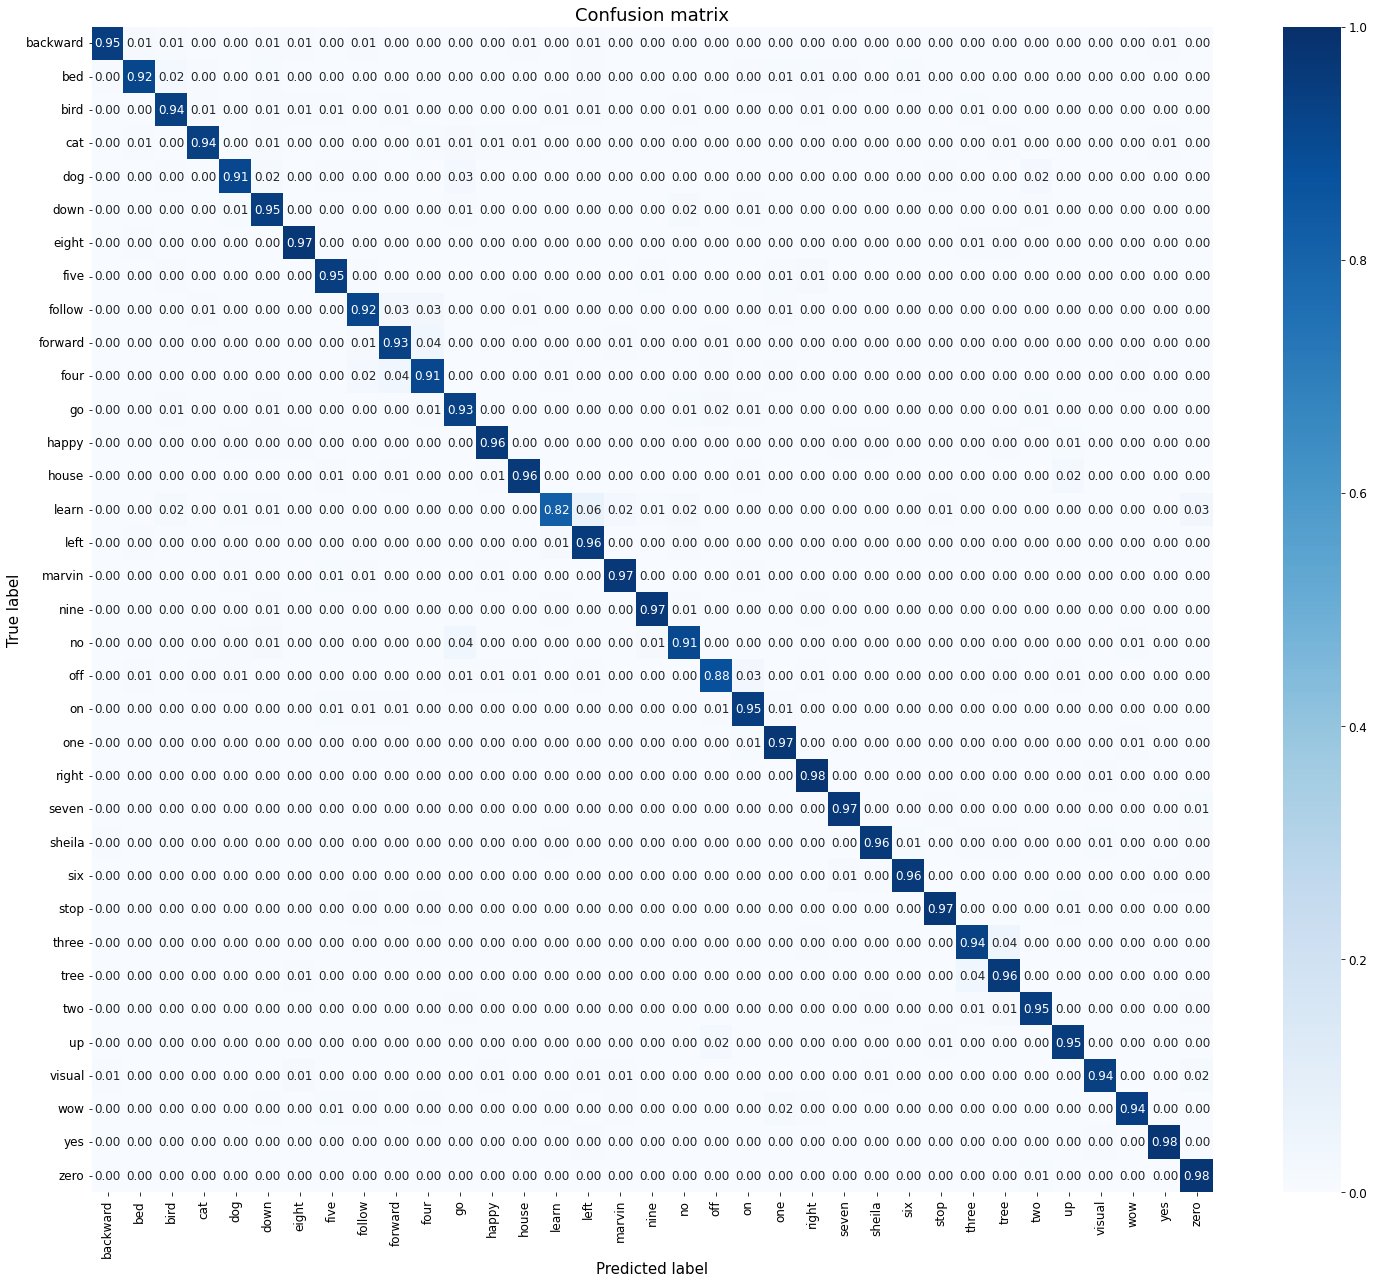

In [ ]:
# get predictions for test set
test_labels = reference_df_test['class']
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(test_labels)].squeeze()

# estimate class
y_pred = np.argmax(test_pred, axis=1)

# true labels
y_true = reference_df_test['class'].tolist()

# plot cm
cm = confusion_matrix(y_pred, y_true)
plot_utils.plot_confusion_matrix(cm, labels=commands, normalize=True, saveit=False, model_name='')

In [ ]:
# get metrics and display them 
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

# print('Accuracy:      {:.2f}%'.format(accuracy*100))
# print('Error rate:    {:.2f}%'.format((1-accuracy)*100))
# print('Cross-entropy: {:.4f}'.format(logloss))
# print("Cohen's Kappa: {:.4f}".format(cohen_k))

cr = class_report(y_true, y_pred)
weighted_metrics = cr.iloc[-1].tolist()

df_metrics_modified = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

display(df_metrics_modified.round(4))

,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.9465,0.9459,0.9459,0.9459,0.1917,0.9441


# Feature Comparison
Here we train the model `custom_cnn_simple` for 20 epochs with different input audio features to perform a feature comparison. Recall that in the function `preprocessing_utils.load_and_preprocess_data` we defined the following features:

```python
features_to_input = { # input shapes
    1 : (99, 39),     # MFCC features with delta
    2 : (99, 40),     # log Mel-filterbank energy features
    3 : (98, 257),    # spectrogram
    4 : (49, 39),     # Discrete Wavelet Transform + MFCC features
    5 : (99, 13)      # MFCC features no delta
}
```

## 7 - FC, training and testing loop


In [26]:
def training_and_testing(feature_selected, df_store=None, noise_red=0.5, random_shift=False):
  # remove cache files
  remove_file_starting_with('train_cache')
  remove_file_starting_with('val_cache')
  remove_file_starting_with('test_cache')

  # create datasets
  train_dataset, train_steps = create_dataset(
      reference_df_train,
      is_train=True,
      cache_file='train_cache',
      shuffle=True,
      apply_background_noise=apply_bn,
      noise_dict=noise_dict,
      noise_reduction=noise_red,
      features=feature_selected,
      batch_size=batch_size,
      random_shift=random_shift
  )

  val_dataset, val_steps = create_dataset(
      reference_df_val,
      is_train=False,
      cache_file='val_cache',
      shuffle=True,
      apply_background_noise=False,
      features=feature_selected,
      batch_size=batch_size,
      random_shift=random_shift
  )

  test_dataset, test_steps = create_dataset(
      reference_df_test,
      is_train=False,
      cache_file='test_cache',
      shuffle=False,
      apply_background_noise=False,
      features=feature_selected,
      batch_size=batch_size
  )

  # input shape
  input_shape = features_to_input[feature_selected]

  # model
  model = custom_cnn_simple(input_shape, *bo_params_redefined)
  model_name = 'custom_cnn_simple_feature_comparison'

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

  # training
  print('Start training... ')
  num_epochs = 2

  early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

  reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)

  history = model.fit(
                  train_dataset,
                  epochs=num_epochs,
                  steps_per_epoch=train_steps,
                  validation_data=val_dataset,
                  validation_steps=val_steps,
                  callbacks=[early_stop_callback, model_checkpoint, reduce_LR], 
                  verbose=0
                  )
  
  print('Training completed!')

  # testing
  print('Testing...')
  test_labels = reference_df_test['class']
  test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(test_labels)].squeeze()

  y_pred = np.argmax(test_pred, axis=1)
  y_true = reference_df_test['class'].tolist()

  accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
  logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
  cohen_k  = cohen_kappa_score(y_true, y_pred)

  cr = class_report(y_true, y_pred)
  weighted_metrics = cr.iloc[-1].tolist()

  df_metrics = pd.DataFrame(
      [weighted_metrics + [accuracy, logloss, cohen_k]], 
      columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
  )

  # store results
  if df_store is not None:
    df_return = pd.concat([df_store, df_metrics])
  else:
    df_return = df_metrics

  # clean memory
  del model
  print('\n')

  return df_return

In [25]:
features_names = ['MFCC_with_delta', 'log_energy', 'spectrogram', 'dwt_mfcc_with_delta', 'MFCC_no_delta']

Let's run the above function for all features and store the resulting metrics.

In [ ]:
for i, feat in enumerate(np.arange(1, 6)):
  print('--- ITERATION %i ---' %i)

  if i==0:
    df_output = training_and_testing(feat)

  else:
    df_output = training_and_testing(feat, df_output)

--- ITERATION 0 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 44s 128ms/step


--- ITERATION 1 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 34s 97ms/step


--- ITERATION 2 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 90s 261ms/step


--- ITERATION 3 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 40s 116ms/step


--- ITERATION 4 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 35s 101ms/step




In [ ]:
df_output.insert(0, 'feature', features_names)
df_output = df_output.set_index('feature')
df_output = df_output.rename_axis(index=None, columns=None)
df_output = df_output.sort_values(by=['cross-entropy'])

display(df_output.round(4))

if not os.path.exists("metrics"):
  os.mkdir('metrics')

df_output.to_csv(f'metrics/metr_feat_comparison.csv')

,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
log_energy,0.8659,0.8590,0.8577,0.8590,0.4718,0.8542
spectrogram,0.8281,0.7906,0.7921,0.7906,0.7041,0.7838
MFCC_no_delta,0.7273,0.7128,0.7130,0.7128,0.9537,0.7033
dwt_mfcc_with_delta,0.6850,0.6692,0.6682,0.6692,1.1174,0.6581
MFCC_with_delta,0.6863,0.6193,0.6146,0.6193,1.2895,0.6070


The best results on the test set are achieved using the logarithm of the raw filterbank energies. It could be argued that this is due to the fact that the Bayesian Optimization was done using this feature, and therefore the reason for this result is precisely that the model we have selected for the comparison is optimized for the log energies. However, from some other tests we did, on unbiased models, we got the same result shown here. 

From now on, we will focus our research on this feature. 

# Extra 1: background noise effect 
It is also possible to study the effect of adding background noise when training the best CNN model. To do this, we train the model applying different noise levels on the train set, while the validation and test sets are kept noise-free. In this procedure we use the best features found in the previous step.

We test the following noise reduction levels:
- 0
- 0.25
- 0.5
- 0.75
- 1 (= zero noise is applied)

In [31]:
print(inspect.getsource(preprocessing_utils.background_noise))

def background_noise(data, noise_dict, select_noise=None, noise_reduction=0.5, *args):
    '''
    data: input audio signal, already loaded and preprocessed, it must be a numpy array 
    select_noise: decide what kind of noise to add to the input signal, by default a random choice 
    noise_reduction: set it to a value between 0 and 1 to reduce the amount of noise, by default 0.8
    '''
    
    # noise selection
    if (select_noise is None) or (select_noise == -1):
        select_noise = np.random.choice(np.arange(1, 7)) # random selection
    noise_data = args[select_noise-1] if (noise_dict == -1) else noise_dict[str(select_noise)]
    
    # random cropping
    target_size = data.shape[0]
    noise_size  = noise_data.shape[0]
    from_       = np.random.randint(0, int(noise_size-target_size))
    to_         = from_ + target_size
    noise_data  = noise_data[from_:to_]
    
    # add noise to input audio
    data_with_noise = data + (1-noise_reduction)*noise_data
    
    return

In [ ]:
noise_red_levels = [0, 0.25, 0.5, 0.75, 1]
features_to_use = 2

for i, nr in enumerate(noise_red_levels):
  print('--- ITERATION %i ---' %i)

  if i==0:
    df_output_noise = training_and_testing(features_to_use, noise_red=nr)

  else:
    df_output_noise = training_and_testing(features_to_use, df_store = df_output_noise, noise_red=nr)

--- ITERATION 0 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 33s 95ms/step


--- ITERATION 1 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 33s 94ms/step


--- ITERATION 2 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 34s 97ms/step


--- ITERATION 3 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 34s 99ms/step


--- ITERATION 4 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 33s 97ms/step




In [ ]:
df_output_noise.insert(0, 'noise_reduction', noise_red_levels)
df_output_noise = df_output_noise.sort_values(by=['cross-entropy'])

df_output_noise.insert(0, 'tmp', range(len(noise_red_levels)))
df_output_noise = df_output_noise.set_index('tmp')
df_output_noise = df_output_noise.rename_axis(index=None, columns=None)

display(df_output_noise.round(4))

if not os.path.exists("metrics"):
  os.mkdir('metrics')

df_output_noise.to_csv(f'metrics/metr_noise_effect.csv')

,noise_reduction,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.50,0.8723,0.8637,0.8631,0.8637,0.4589,0.8591
1,0.25,0.8578,0.8480,0.8482,0.8480,0.4954,0.8429
2,1.00,0.8613,0.8515,0.8525,0.8515,0.4963,0.8465
3,0.00,0.8647,0.8485,0.8508,0.8485,0.5054,0.8435
4,0.75,0.8549,0.8417,0.8428,0.8417,0.5308,0.8363


From the resulting metrics, we can see that the best performance is achieved with a noise reduction level of 0.5. This explains our previous choice of setting `noise_reduction=0.5`. 

# Extra 2: random time shift effect
Finally, we want to see if shifting the input signal by a random amount in $[-100, 100]$ ms helps improving the model performance. This idea is implemented in many papers we read, and it is motivated by the fact that in a real-time keyword detector the input signal may be not centered in the selected time window. 

As any other data augmentation technique, it is performed only on the training dataset, as we believe the validation and test sets should not be modified, in particular the last one, for comparison reasons.

In [32]:
print(inspect.getsource(preprocessing_utils.random_time_shift))

def random_time_shift(data, low=-100, high=100):
    
    y_shift = int(np.random.uniform(low, high)*16)

    if y_shift >= 0:
        data = np.pad(data[y_shift:], pad_width=(0, y_shift), mode='mean')
    else: 
        data = np.pad(data[:len(data)+y_shift], pad_width=(-y_shift, 0), mode='mean')

    return data.astype(np.float32)



In [32]:
time_shift = [False, True]
features_to_use = 2

print('--- ITERATION 0 ---')
df_output_no_ts = training_and_testing(features_to_use, random_shift=False)

print('--- ITERATION 1 ---')
df_output_si_ts = training_and_testing(features_to_use, random_shift=True)

df_output_ts = pd.concat([df_output_no_ts, df_output_si_ts])

--- ITERATION 0 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 44s 127ms/step


--- ITERATION 1 ---
Start training... 
Training completed!
Testing...
344/344 [==============================] - 50s 146ms/step




In [37]:
df_output_ts.insert(0, 'random_time_shift', time_shift)
df_output_ts = df_output_ts.sort_values(by=['cross-entropy'])

df_output_ts.reset_index(inplace=True, drop=True)


display(df_output_ts.round(4))

if not os.path.exists("metrics"):
  os.mkdir('metrics')

df_output_ts.to_csv(f'metrics/metr_time_shift_effect.csv')

,random_time_shift,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,False,0.8695,0.8552,0.8563,0.8552,0.4956,0.8503
1,True,0.8362,0.8034,0.8067,0.8034,0.6344,0.7967


Contrary to expectations, incliding the random shift in the preprocessing pipeline does not help improve the model performance. However, even if we will not use it on the next models we implement, we still believe it can be meaningful to include a random shift in the training set, especially if the final goal is to use the model on real-time input signals, which obviously will not be as centered as the data in our test set.

# References
**[Sainath15]** <br>
 Tara N. Sainath, Carolina Parada, _Convolutional Neural Networks for Small-footprint Keyword Spotting_, INTERSPEECH, Dresden, Germany, September 2015.

**[Warden18]** <br>
 Pete Warden, _Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition_, arXiv:1804.03209, April 2018. 
 
**[Lyons14]** <br>
 James Lyons et al. (2020, January 14). jameslyons/python_speech_features: release v0.6.1 (Version 0.6.1). Zenodo.
